In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
data = pd.read_excel('DynamicData_for_prediction.xlsx')


In [3]:
# Выделение признаков, целевой переменной и года
years = data['YEARS'].values
features = data[['X:P1', 'Y:P1', 'X:P2', 'Y:P2', 'X:P3', 'Y:P3']].values
target = data[['WOPR:P1', 'WOPR:P2', 'WOPR:P3']].values


In [4]:
# Нормализация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [5]:
# Разделение данных на обучающую и валидационную выборки
features_train, features_val, target_train, target_val, years_train, years_val = train_test_split(
    features, target, years, test_size=0.2, shuffle=False)


In [6]:
# Преобразование данных в графовое представление
# Создаем список ребер для всех вершин
edges = []
num_nodes = features_train.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        edges.append([i, j])
        edges.append([j, i])


In [7]:
# Преобразуем список ребер в формат PyTorch
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()


In [8]:
# Создаем объект Data для обучающего графа
train_data = Data(x=torch.tensor(features_train, dtype=torch.float32),
                  edge_index=edges,
                  y=torch.tensor(target_train, dtype=torch.float32))


In [9]:
# Преобразуем список ребер для валидационного графа
edges_val = []
num_nodes_val = features_val.shape[0]
for i in range(num_nodes_val):
    for j in range(i + 1, num_nodes_val):
        edges_val.append([i, j])
        edges_val.append([j, i])

In [10]:
# Преобразуем список ребер в формат PyTorch для валидационного графа
edges_val = torch.tensor(edges_val, dtype=torch.long).t().contiguous()


In [11]:
# Создаем объект Data для валидационного графа
val_data = Data(x=torch.tensor(features_val, dtype=torch.float32),
                edge_index=edges_val,
                y=torch.tensor(target_val, dtype=torch.float32))


In [33]:
# Определение архитектуры GCN модели
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(6, 36)
        self.conv2 = GCNConv(36, 12)
        self.conv3 = GCNConv(12, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

In [34]:
# Инициализация модели и оптимизатора
model = GCN()
optimizer = Adam(model.parameters(), lr=0.01)

In [35]:
# Обучение модели
model.train()
for epoch in range(10000):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')


Epoch 0, Loss 6890.951171875
Epoch 10, Loss 6879.451171875
Epoch 20, Loss 6867.97412109375
Epoch 30, Loss 6856.52294921875
Epoch 40, Loss 6845.10009765625
Epoch 50, Loss 6833.70556640625
Epoch 60, Loss 6822.3408203125
Epoch 70, Loss 6811.005859375
Epoch 80, Loss 6799.69970703125
Epoch 90, Loss 6788.4228515625
Epoch 100, Loss 6777.17578125
Epoch 110, Loss 6765.95751953125
Epoch 120, Loss 6754.76904296875
Epoch 130, Loss 6743.60986328125
Epoch 140, Loss 6732.47802734375
Epoch 150, Loss 6721.37744140625
Epoch 160, Loss 6710.3056640625
Epoch 170, Loss 6699.26171875
Epoch 180, Loss 6688.2470703125
Epoch 190, Loss 6677.26025390625
Epoch 200, Loss 6666.3037109375
Epoch 210, Loss 6655.375
Epoch 220, Loss 6644.474609375
Epoch 230, Loss 6633.6025390625
Epoch 240, Loss 6622.75927734375
Epoch 250, Loss 6611.9443359375
Epoch 260, Loss 6601.158203125
Epoch 270, Loss 6590.39892578125
Epoch 280, Loss 6579.66845703125
Epoch 290, Loss 6568.96533203125
Epoch 300, Loss 6558.291015625
Epoch 310, Loss 6547.

KeyboardInterrupt: 

In [22]:
# Предсказание на валидационных данных
model.eval()
with torch.no_grad():
    pred_val = model(val_data)

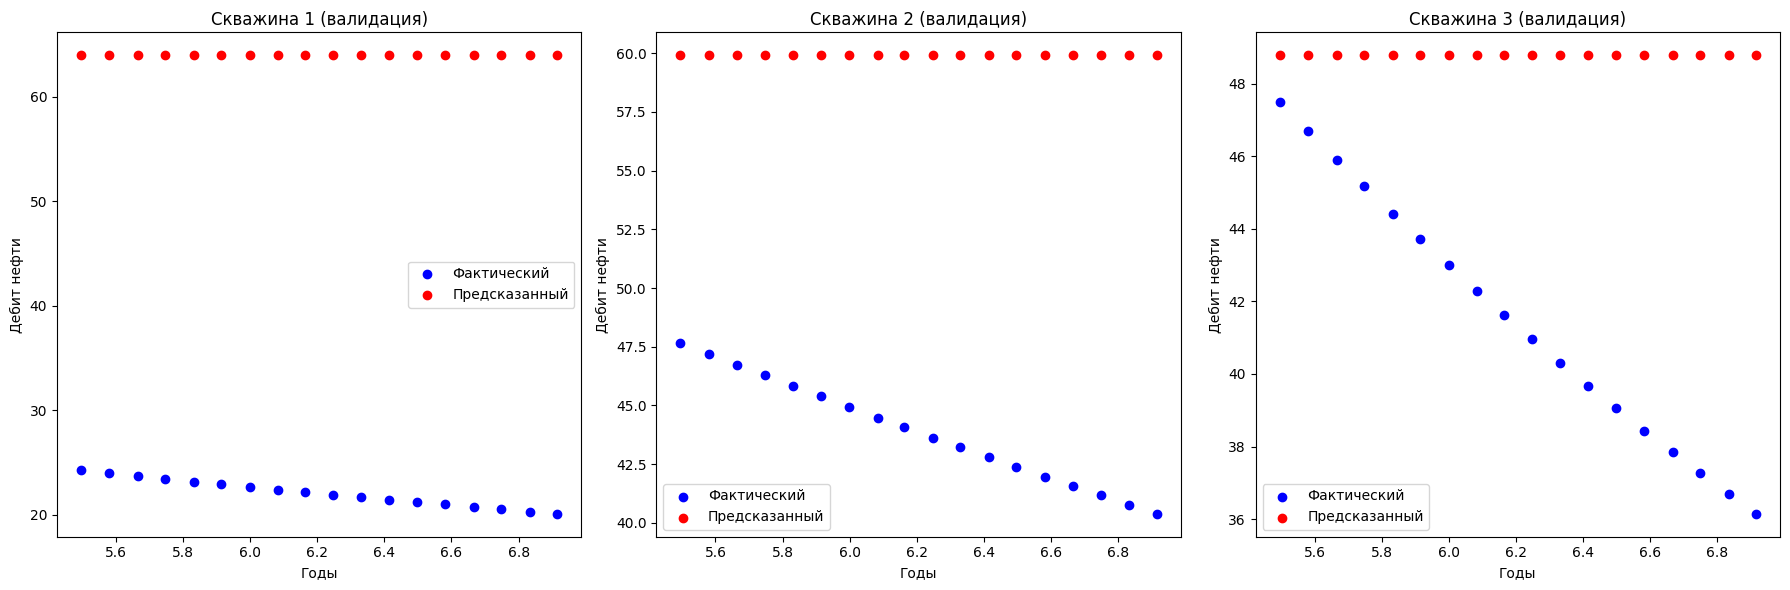

In [23]:
# Визуализация результатов для валидационной выборки
plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(years_val, target_val[:, i], label='Фактический', color='blue')
    plt.scatter(years_val, pred_val[:, i], label='Предсказанный', color='red')
    plt.xlabel('Годы')
    plt.ylabel('Дебит нефти')
    plt.title(f'Скважина {i+1} (валидация)')
    plt.legend()
plt.tight_layout()
plt.show()

In [39]:
import pandas as pd

# Загрузить данные из файла с заголовками
df = pd.read_excel('DynamicData_for_prediction.xlsx')

# Создать список заголовков для столбцов, для которых нужно вычислить среднее
columns_to_mean = [col for col in df.columns if 'poro:I' in col or 'perm:I' in col]

# Вычислить средние значения для столбцов 'poro:I' и 'perm:I'
mean_values = df[columns_to_mean].mean()

# Создать DataFrame с средними значениями
mean_df = pd.DataFrame([mean_values], columns=columns_to_mean)

# Взять первую строку после заголовка для остальных столбцов
first_rows = df.iloc[1].to_frame().T

# Объединить средние значения и первую строку после заголовка
result_df = pd.concat([mean_df, first_rows], axis=1)

# Записать DataFrame в файл Excel
result_df.to_excel('new_excel_file.xlsx', index=False)


In [40]:
import pandas as pd

# Загрузить данные из файла с заголовками
df = pd.read_excel('new_excel_file.xlsx')

# Создать список заголовков для столбцов, которые нужно оставить
columns_to_keep = ['X:I1', 'Y:I1', 'poro:I1', 'perm:I1',
                   'X:I2', 'Y:I2', 'poro:I2', 'perm:I2',
                   'X:I3', 'Y:I3', 'poro:I3', 'perm:I3',
                   'X:P1', 'Y:P1', 'poro:P1', 'perm:P1',
                   'X:P2', 'Y:P2', 'poro:P2', 'perm:P2',
                   'X:P3', 'Y:P3', 'poro:P3', 'perm:P3']

# Удалить лишние столбцы
df = df[columns_to_keep]

# Записать DataFrame в файл Excel
df.to_excel('For_graph.xlsx', index=False)